In [1]:
%cd /home/yokoyama/ahar
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

sys.path.append(".")
from modules.individual import IndividualActivityRecognition, IndividualDataFormat, IndividualDataHandler
from modules.utils.constants import Stages

/raid6/home/yokoyama/ahar


In [ ]:
# set constants
model_type = "ganomaly"
train_data_dir = os.path.join("data", "dataset01", "train")
test_data_dir = os.path.join("data", "dataset01", "test")
data_types = ["bbox", "local"]
seq_len = 300
masking = True

In [ ]:
# load results
def load_results(data_dir, model_type, data_type, seq_len, data_keys):
    results = {}
    for data_dir in tqdm(sorted(glob(os.path.join(data_dir, "*")))):
        video_num = os.path.basename(data_dir)
        results[video_num] = IndividualDataHandler.load(data_dir, model_type, data_type, masking, seq_len, data_keys)

    return results

In [ ]:
data_keys = [IndividualDataFormat.loss_r, IndividualDataFormat.loss_d]
train_results = {}
test_results = {}
for data_type in data_types:
    train_results[data_type] = load_results(train_data_dir, model_type, data_type, seq_len, data_keys)
    test_results[data_type] = load_results(test_data_dir, model_type, data_type, seq_len, data_keys)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
def get_results_ind(results):
    results_ind = {}
    for video_num, video_results in tqdm(results.items()):
        ind_results = {}
        for item in video_results:
            pid = item[IndividualDataFormat.id]
            if pid not in ind_results:
                # initialize individual data
                ind_results[pid] = {
                    key: [] for key in IndividualDataFormat.get_keys()
                    if key != IndividualDataFormat.id
                }

            # append individual data
            for key, value in item.items():
                if key != IndividualDataFormat.id:
                    ind_results[pid][key].append(item[key])
        results_ind[video_num] = ind_results
    return results_ind

In [ ]:
train_results_ind = {}
test_results_ind = {}
for data_type in data_types:
    results = get_results_ind(train_results[data_type])
    # change data structure
    for video_num, vals in results.items():
        if video_num not in train_results_ind:
            train_results_ind[video_num] = {}
        train_results_ind[video_num][data_type] = vals

    results = get_results_ind(test_results[data_type])
    # change data structure
    for video_num, vals in results.items():
        if video_num not in test_results_ind:
            test_results_ind[video_num] = {}
        test_results_ind[video_num][data_type] = vals

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
def calc_minmax(results):
    maxs = {data_type: {IndividualDataFormat.loss_r: 0, IndividualDataFormat.loss_d: 0} for data_type in data_types}
    mins = {data_type: {IndividualDataFormat.loss_r: 0, IndividualDataFormat.loss_d: 0} for data_type in data_types}
    for video_num, video_results in results.items():
        for data_type, ind_results in video_results.items(): 
            for ind_result in ind_results.values():
                for key in [IndividualDataFormat.loss_r, IndividualDataFormat.loss_d]:
                    val = ind_result[key]
                    maxs[data_type][key] = max(maxs[data_type][key], max(val))
                    mins[data_type][key] = min(mins[data_type][key], min(val))
    print("max", maxs)
    print("min", mins)
    
print("train")
calc_minmax(train_results_ind)
print("test")
calc_minmax(test_results_ind)

train
max {'bbox': {'loss_resitudal': 0.13128766, 'loss_discrimination': 0.00017110072}, 'local': {'loss_resitudal': 0, 'loss_discrimination': 6.4140186e-06}}
min {'bbox': {'loss_resitudal': 0, 'loss_discrimination': 0}, 'local': {'loss_resitudal': 0, 'loss_discrimination': 0}}
test
max {'bbox': {'loss_resitudal': 0.1996415, 'loss_discrimination': 0.00026402622}, 'local': {'loss_resitudal': 0, 'loss_discrimination': 5.2675605e-06}}
min {'bbox': {'loss_resitudal': 0, 'loss_discrimination': 0}, 'local': {'loss_resitudal': 0, 'loss_discrimination': 0}}


In [ ]:
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams["font.size"] = 20
# plt.rcParams['xtick.direction'] = 'in'  # x axis in
# plt.rcParams['ytick.direction'] = 'in'  # y axis in

max_frame_num = 5400

def collect_result_value(vals, frame_nums, max_frame_num):
    vals = {f: v for f, v in zip(frame_nums, vals)}
    x, y = [], []
    for frame_num in range(max_frame_num):
        frame_num += 1
        x.append(frame_num)
        if frame_num in frame_nums:
            y.append(vals[frame_num])
        else:
            y.append(np.nan)
    return x, y


def set_ylim(axs):
    i = 0
    axs[i][0].set_ylim(0.0, 0.3)  # bbox residual
    axs[i][1].set_ylim(0.0, 5.0)  # bbox discrimination
    i += 1
    axs[i][0].set_ylim(0.0, 0.2)  # local residual
    axs[i][1].set_ylim(0.0, 4.0)  # local discrimination
    
    
def set_ylim_anomaly(axs):
    i = 0
    axs[0].set_ylim(0.0, 0.30)  # bbox
    axs[1].set_ylim(0.0, 3.2)  # local


def plot(results, max_frame_num, stage):
    for video_num, video_results in results.items():
        fig, axs = plt.subplots(len(video_results), 2, figsize=(16, 3 * len(video_results)))
        fig.subplots_adjust(hspace=0.4, wspace=0.15)
        for i, (data_type, ind_results) in enumerate(video_results.items()): 
            for pid, results in ind_results.items():
                frame_nums = results[IndividualDataFormat.frame_num]
                loss_resi = results[IndividualDataFormat.loss_r]
                loss_disc = results[IndividualDataFormat.loss_d]
                
                x_resi, y_resi = collect_result_value(loss_resi, frame_nums, max_frame_num)
                x_disc, y_disc = collect_result_value(loss_disc, frame_nums, max_frame_num)

                axs[i][0].plot(x_resi, y_resi, label=pid)
                axs[i][0].set_xlabel("frame")
                axs[i][0].set_ylabel("residual loss")
                axs[i][1].plot(x_disc, y_disc, label=pid)
                axs[i][1].set_xlabel("frame")
                axs[i][1].set_ylabel("discrimination loss")

        axs[0][1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        set_ylim(axs)
        
        # save fig
        path = os.path.join(
            "data", "images", "individual", model_type, "anomaly", f"{stage}", f"{video_num}.jpg"
        )
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path, bbox_inches='tight')
        
        # show
        print(video_num)
        plt.show()
        
        
def plot_anomaly(results, max_frame_num, stage, lmd=0.9):
    for video_num, video_results in results.items():
        fig, axs = plt.subplots(len(video_results), 1, figsize=(16, 3 * len(video_results)))
        fig.subplots_adjust(hspace=0.3, wspace=0.15)
        for i, (data_type, ind_results) in enumerate(video_results.items()): 
            for pid, results in ind_results.items():
                frame_nums = results[IndividualDataFormat.frame_num]
                loss_resi = results[IndividualDataFormat.loss_r]
                loss_disc = results[IndividualDataFormat.loss_d]
                anomaly = lmd * np.array(loss_resi) + (1 - lmd) * np.array(loss_disc)
                
                x, y = collect_result_value(anomaly, frame_nums, max_frame_num)

                axs[i].plot(x, y, label=pid)
                axs[i].set_xlabel("frame")
                axs[i].set_ylabel("residual loss")

        axs[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        # set_ylim_anomaly(axs)
        
        # save fig
        # path = os.path.join(
        #     "data", "images", "individual", model_type, "anomaly", f"{stage}", f"{video_num}.jpg"
        # )
        # os.makedirs(os.path.dirname(path), exist_ok=True)
        # plt.savefig(path, bbox_inches='tight')
        
        # show
        print(video_num)
        plt.show()

# Train Data

01


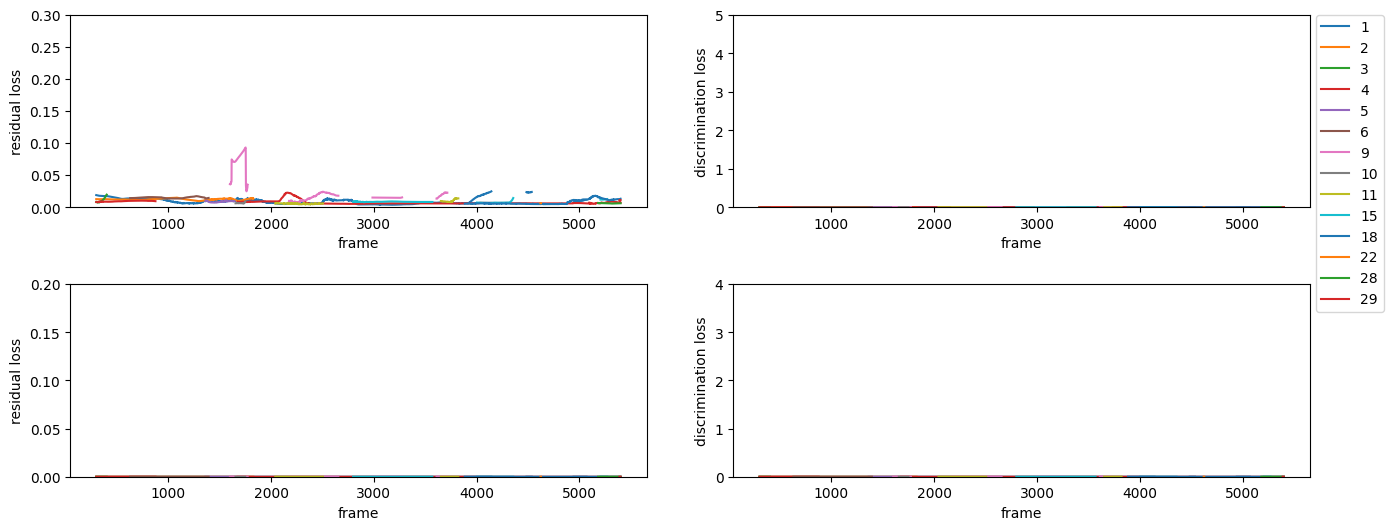

02


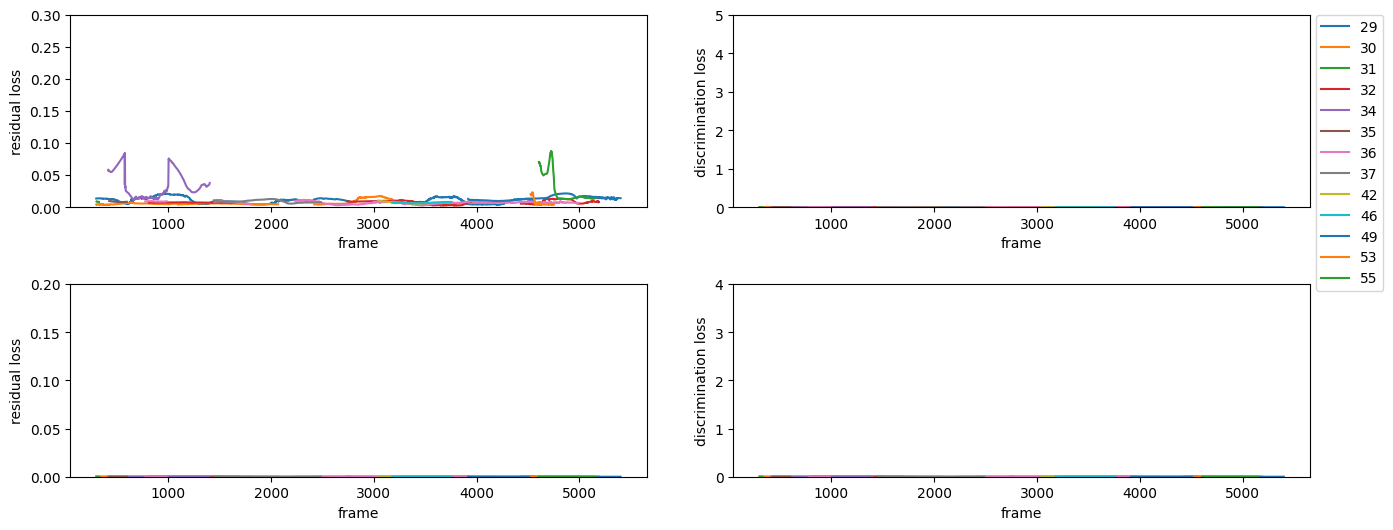

03


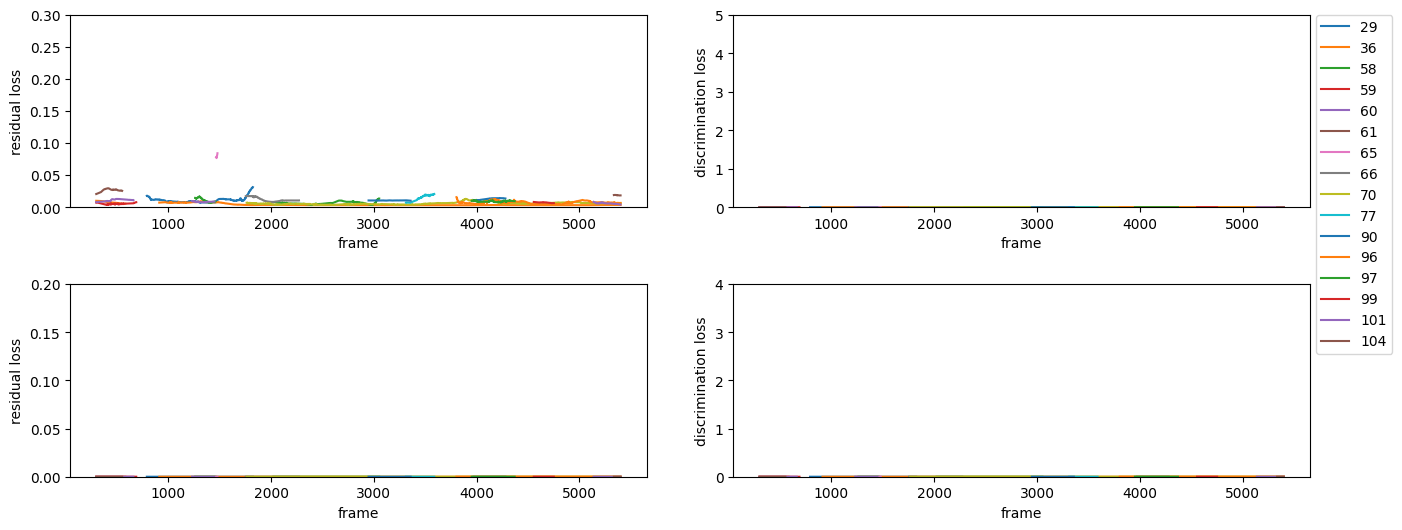

04


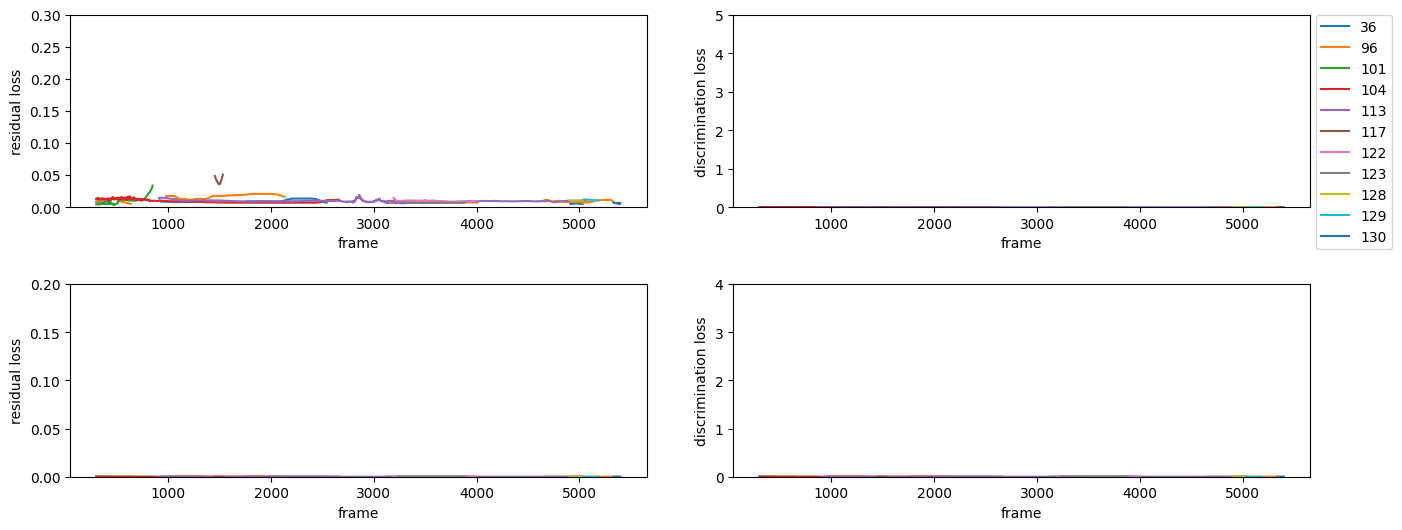

05


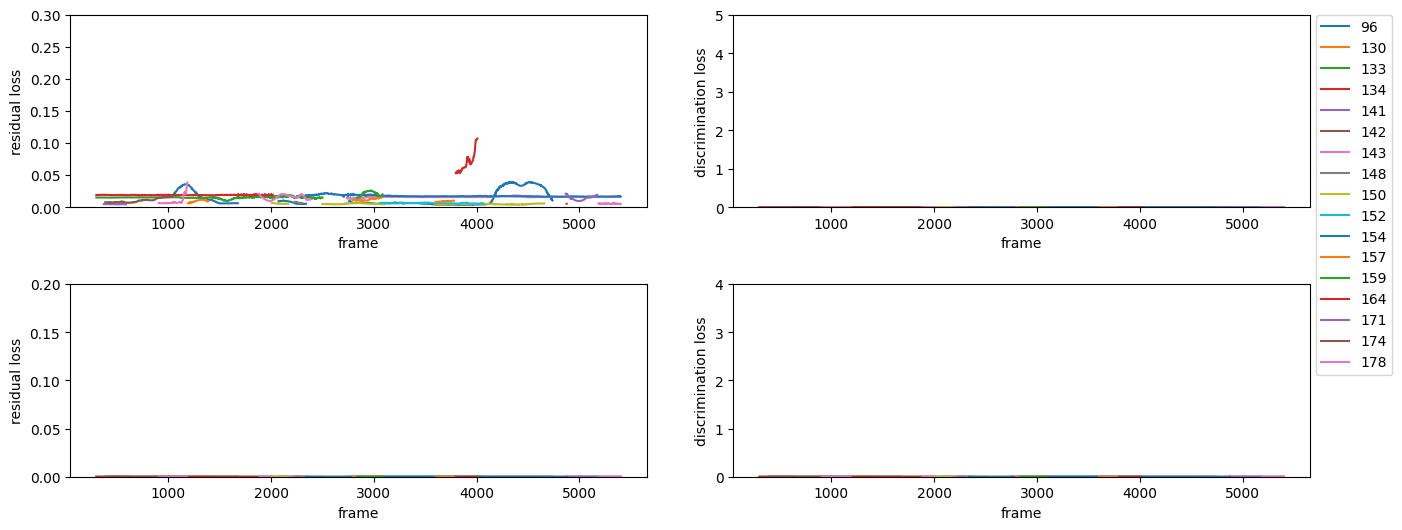

06


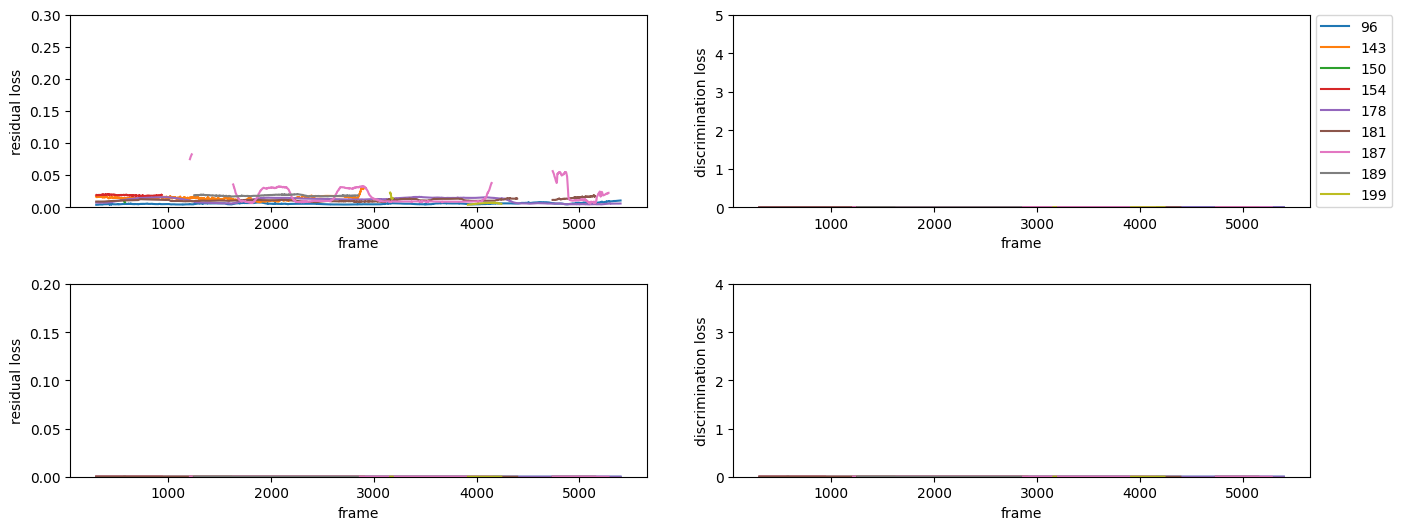

07


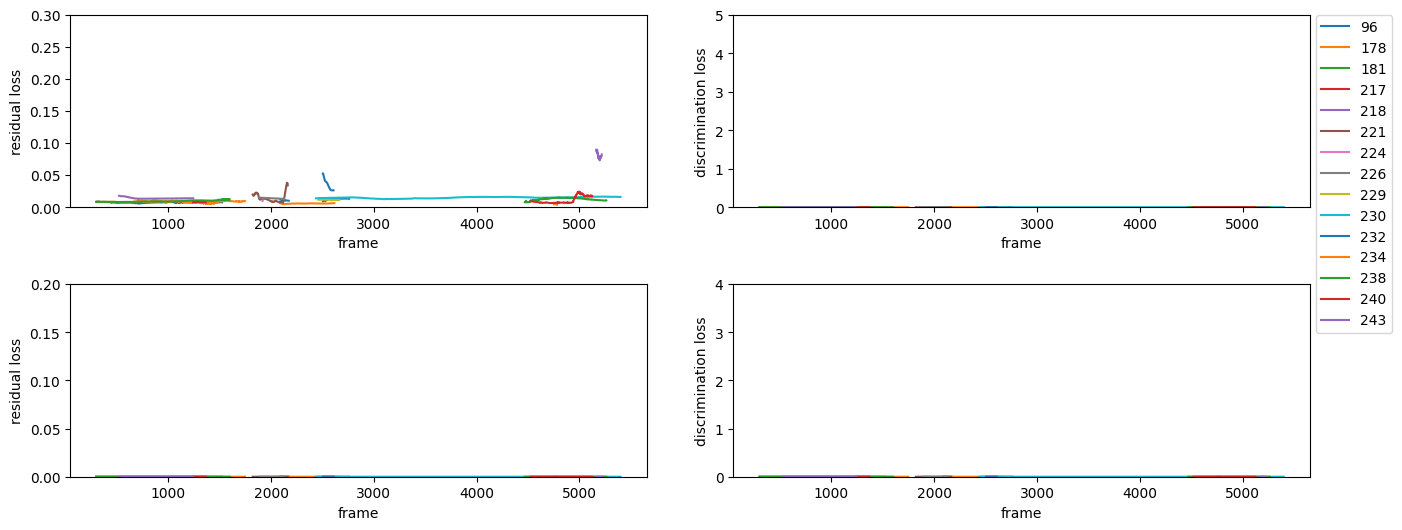

08


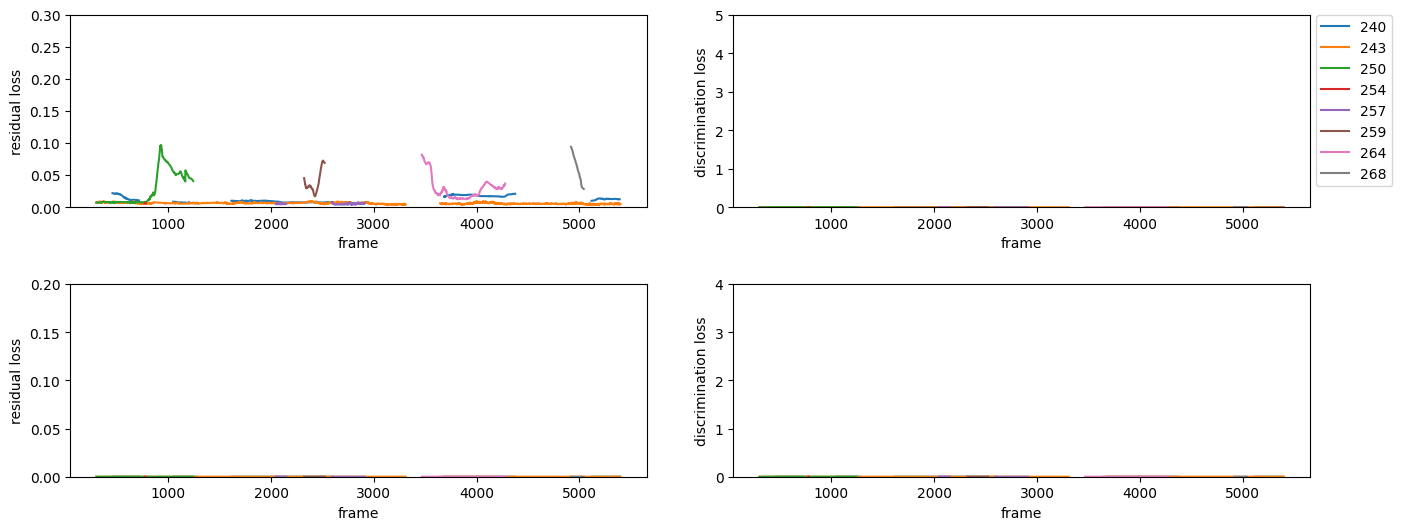

09


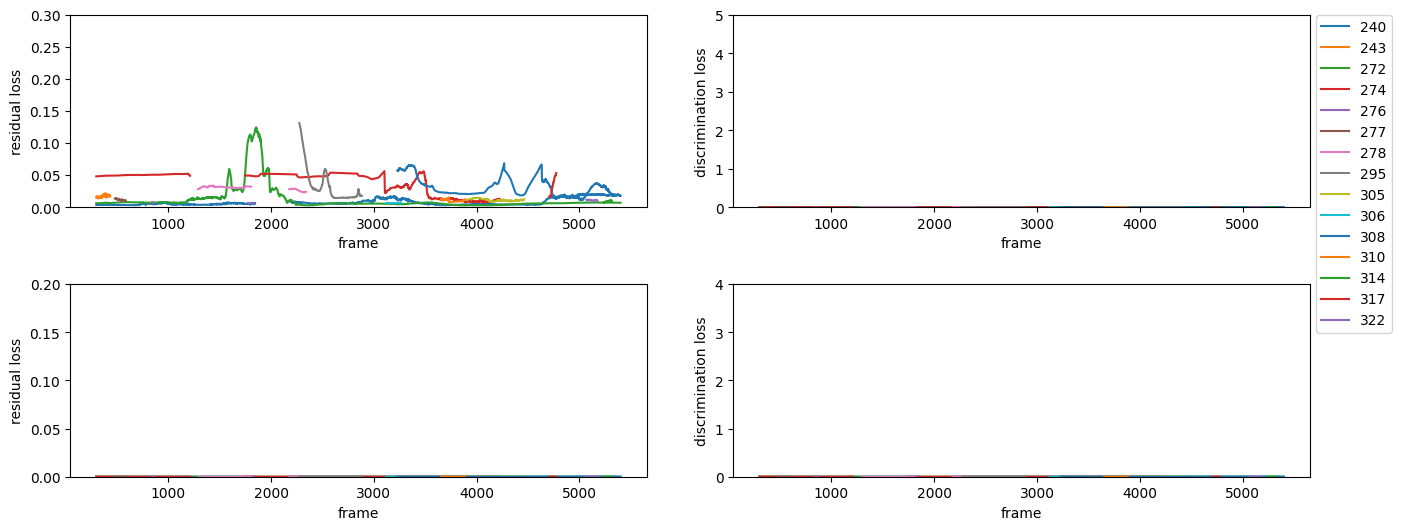

10


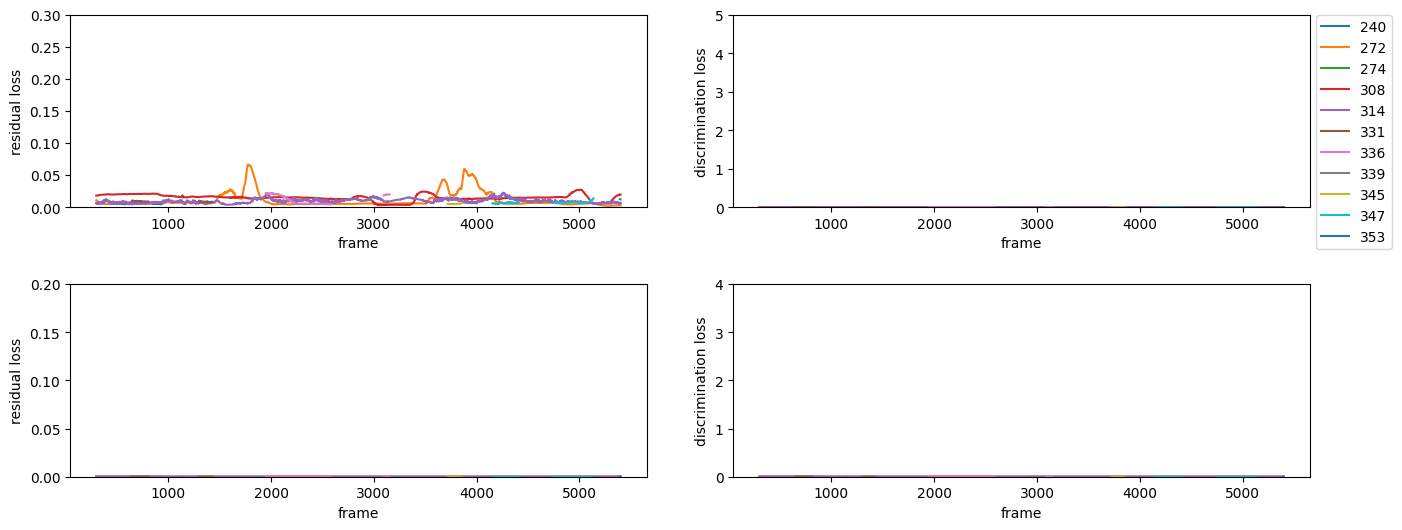

11


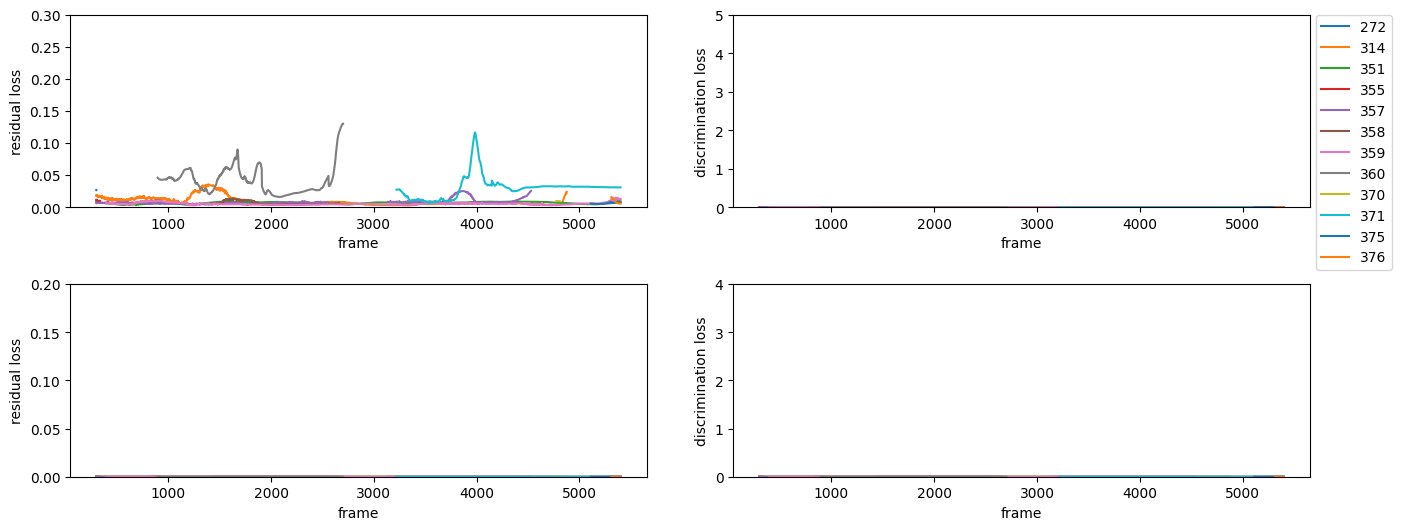

12


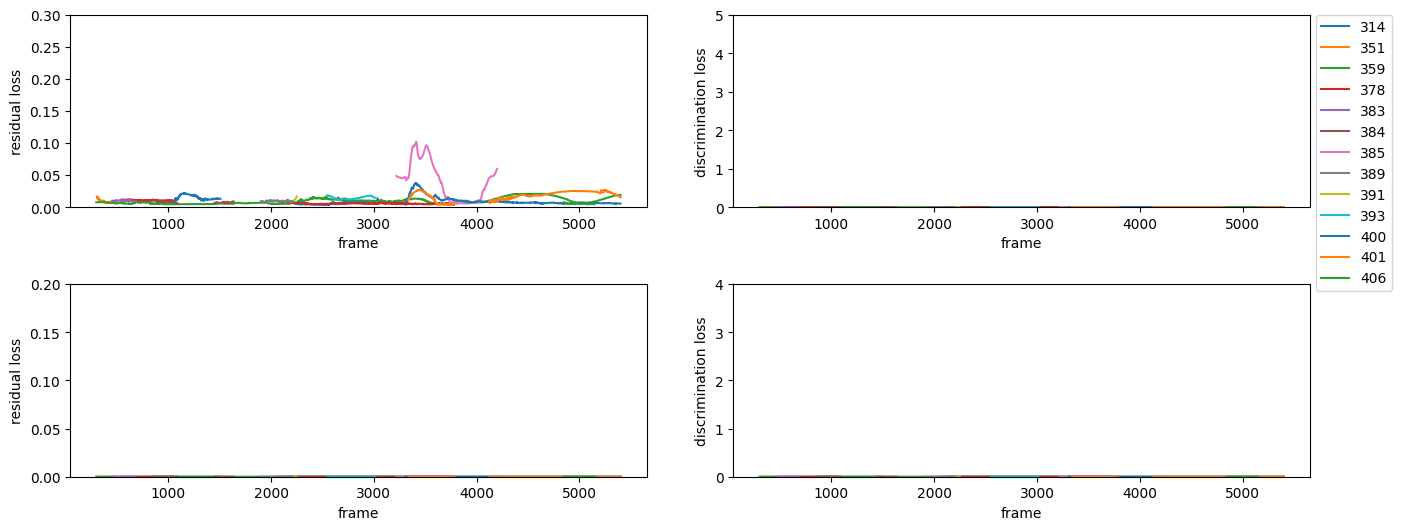

13


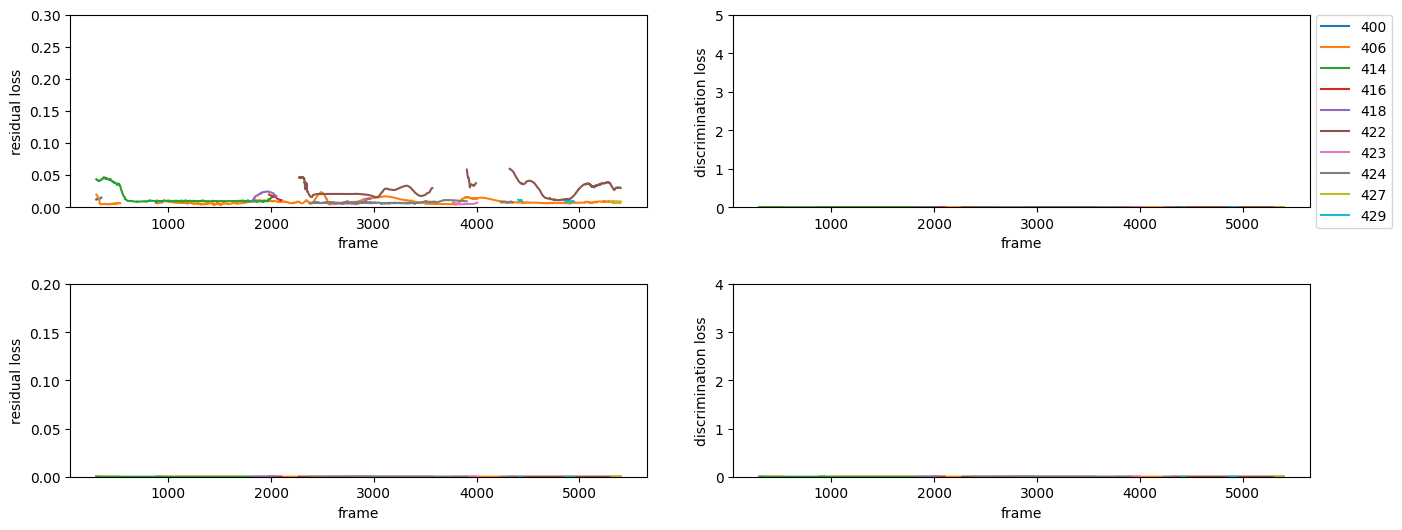

14


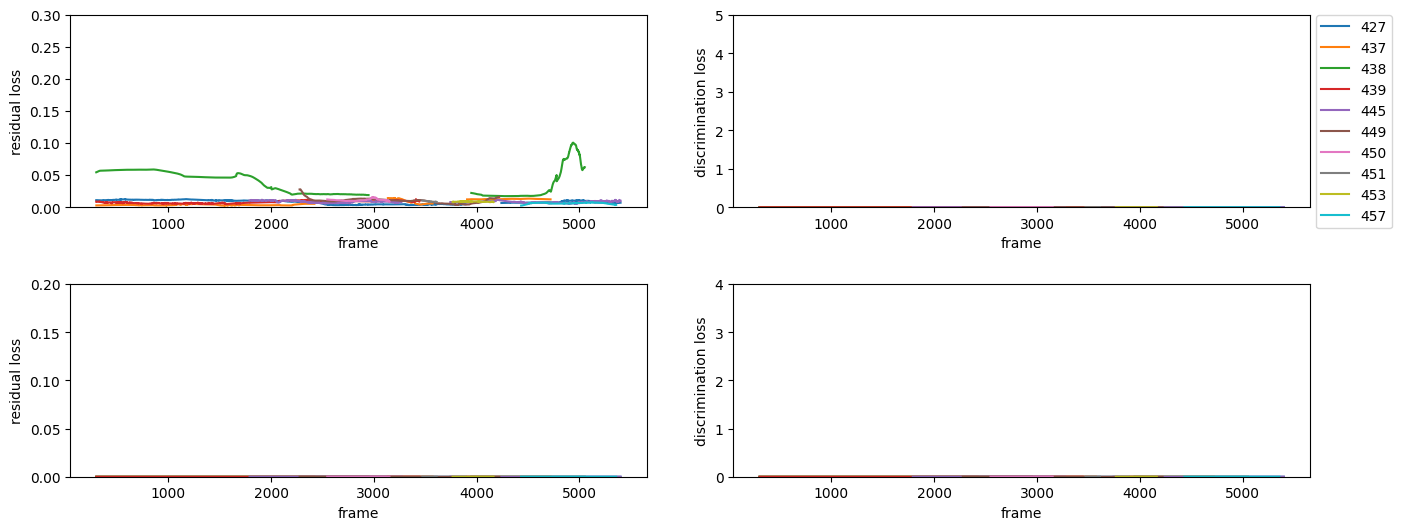

15


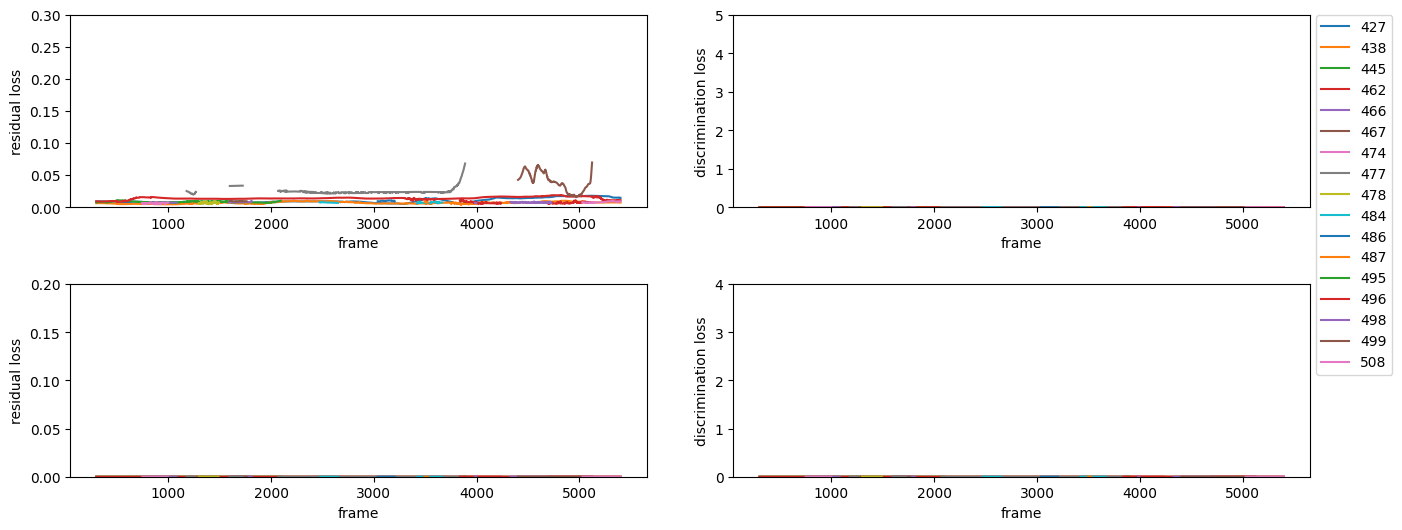

16


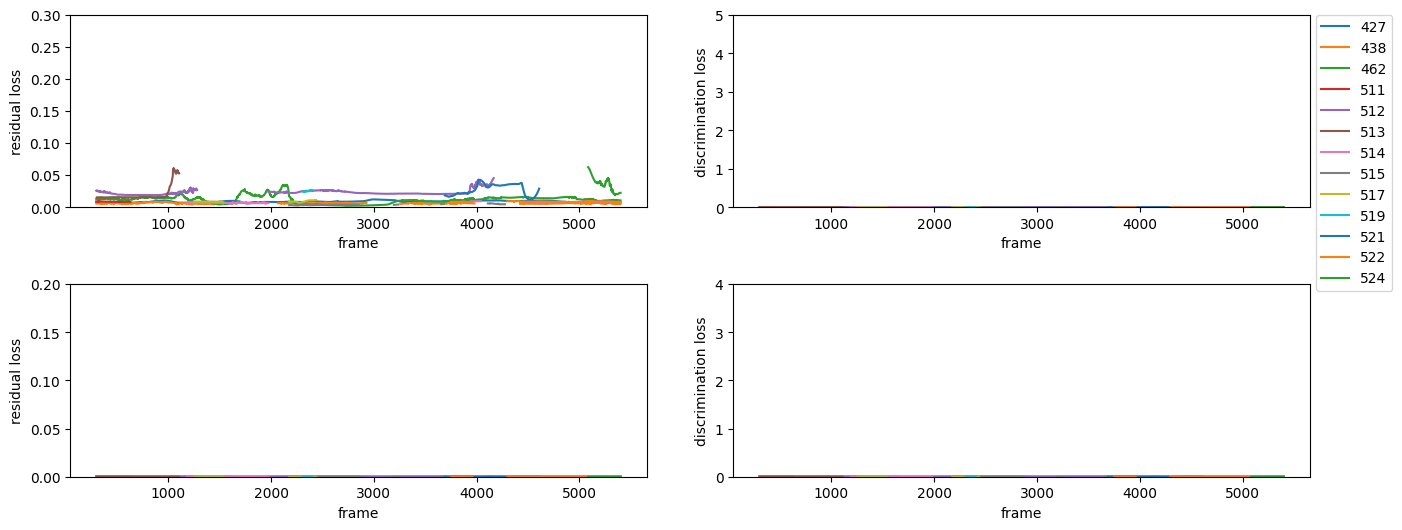

17


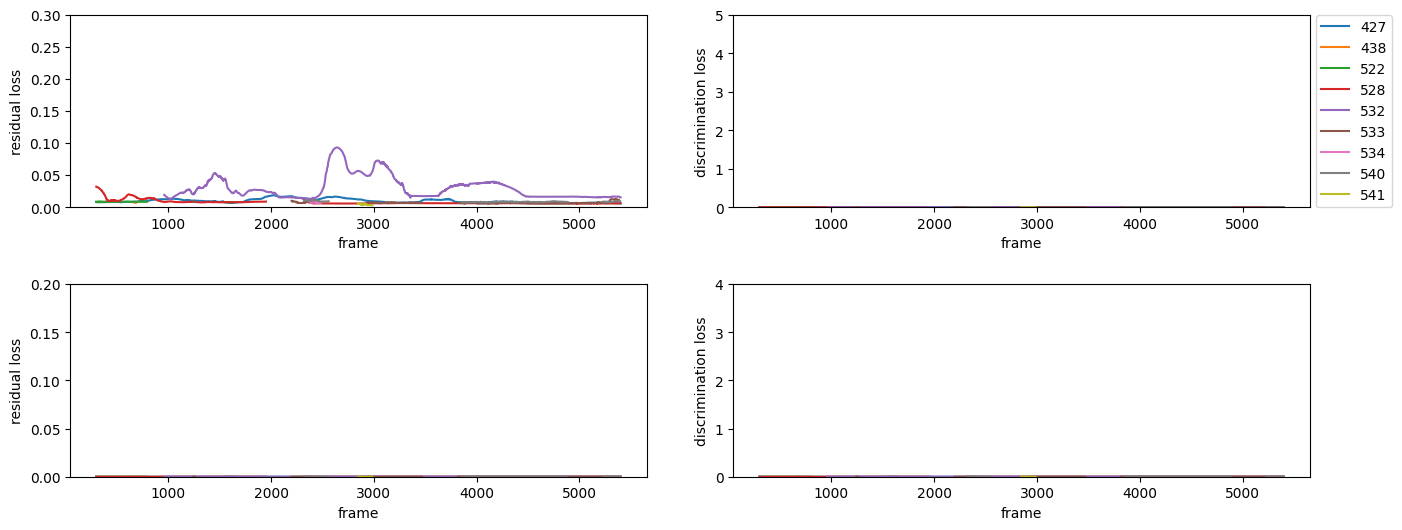

18


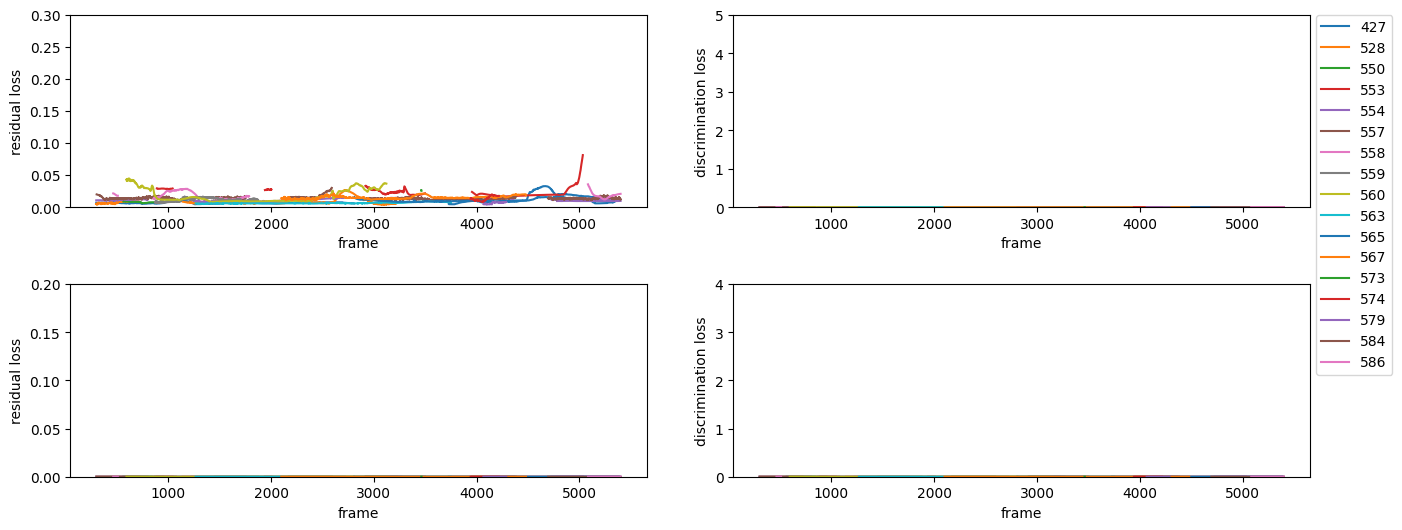

19


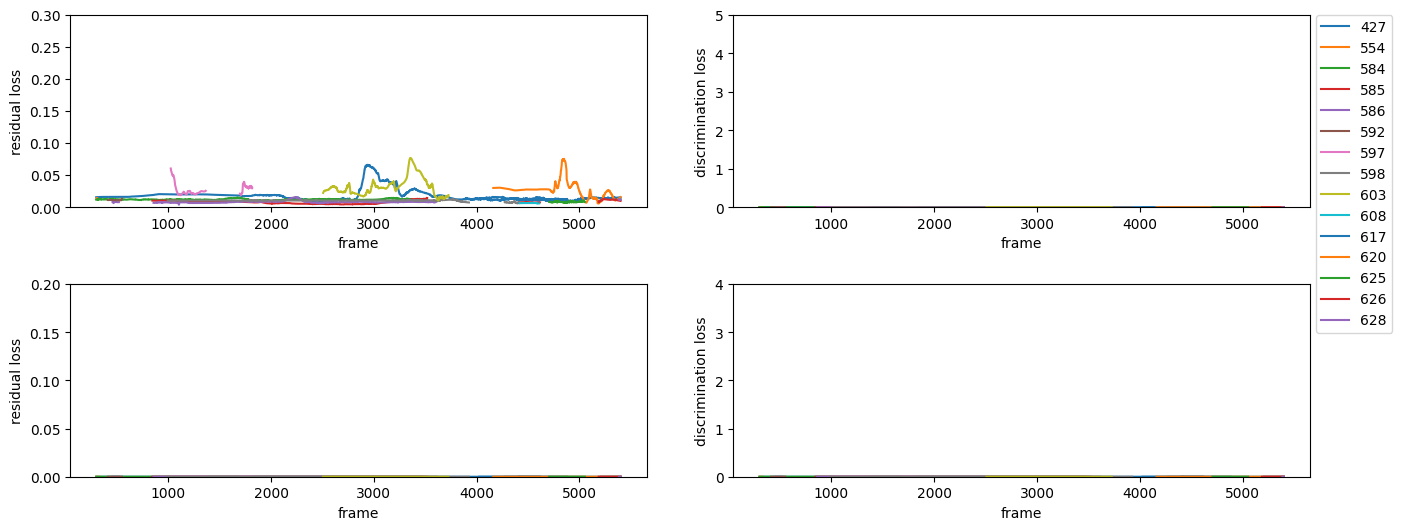

20


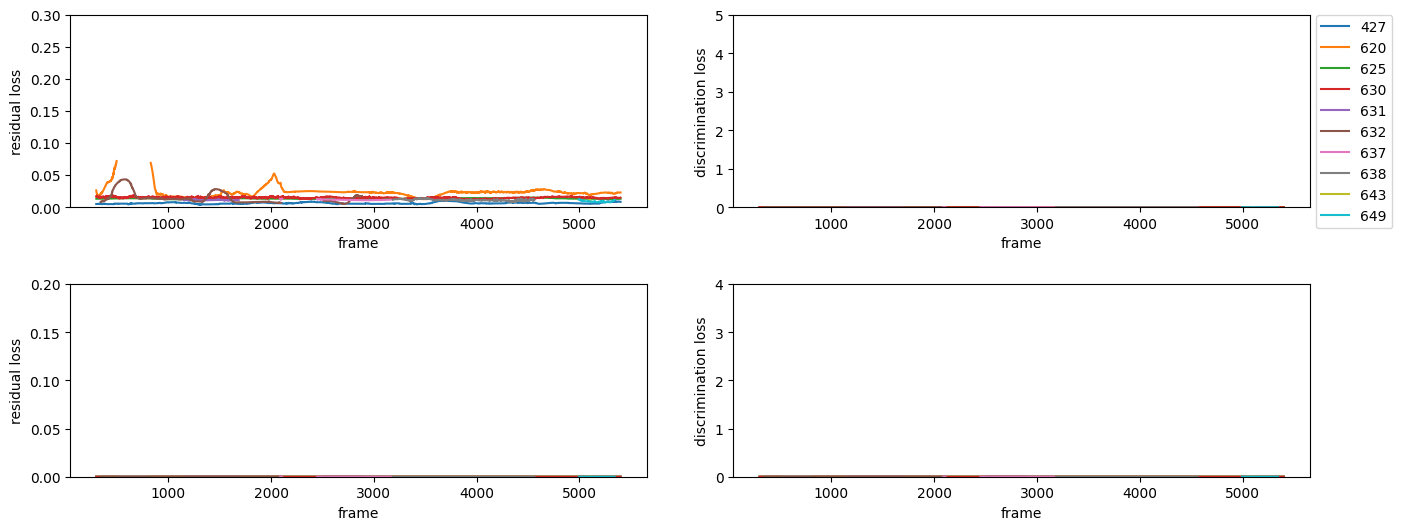

In [ ]:
plot(train_results_ind, max_frame_num, "train")

In [ ]:
# plot_anomaly(train_results_ind, max_frame_num, "train", lmd=0.9)

# Test Data

01


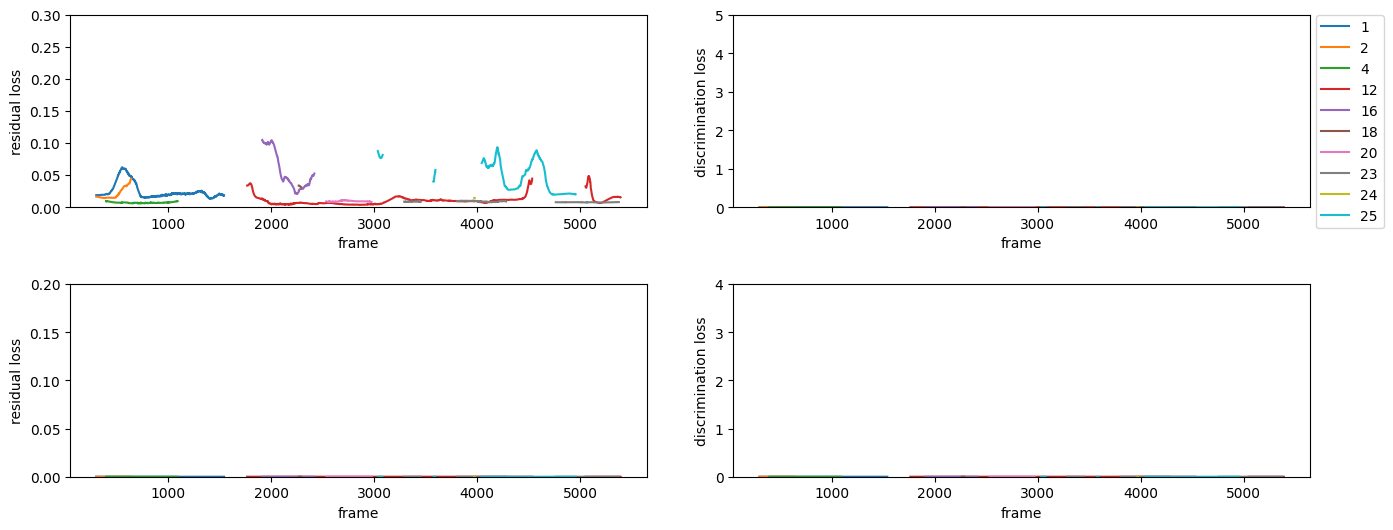

02


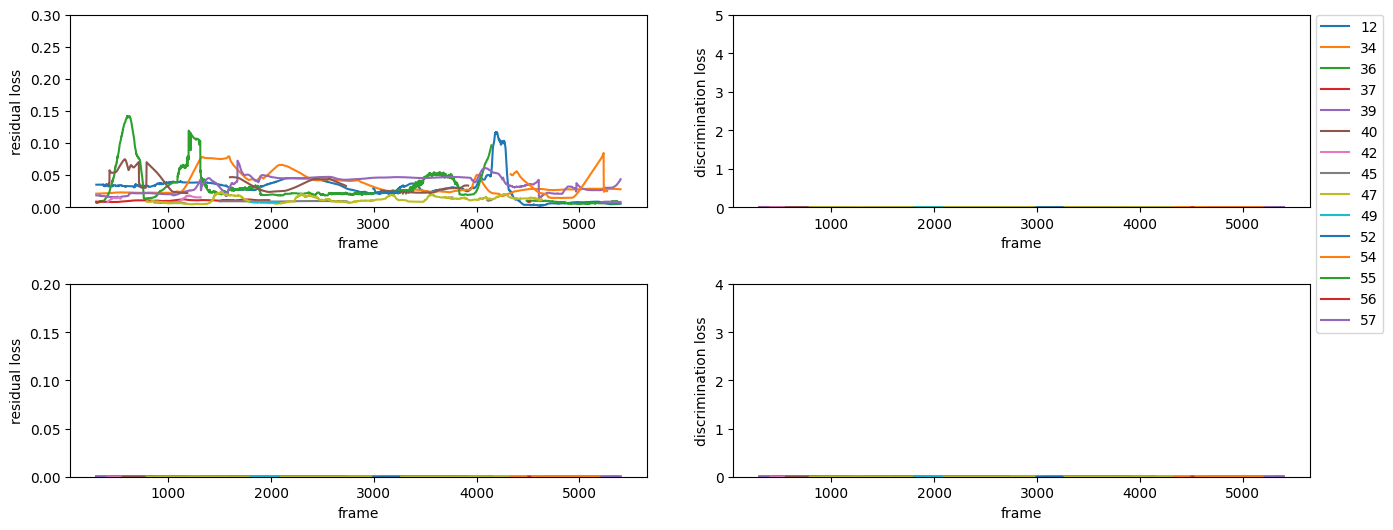

03


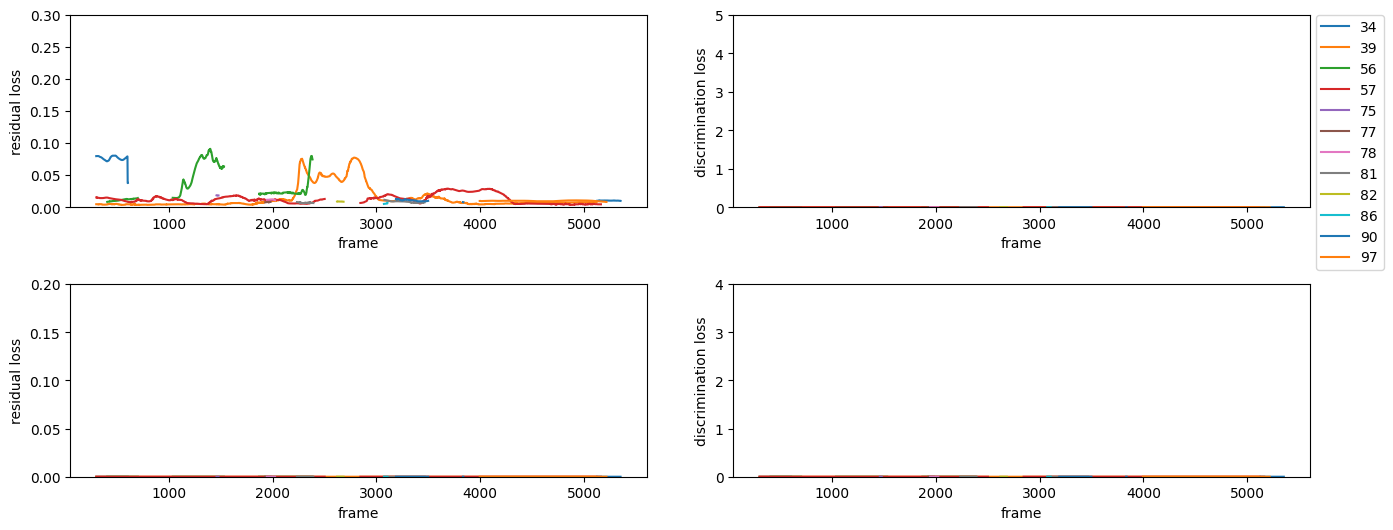

04


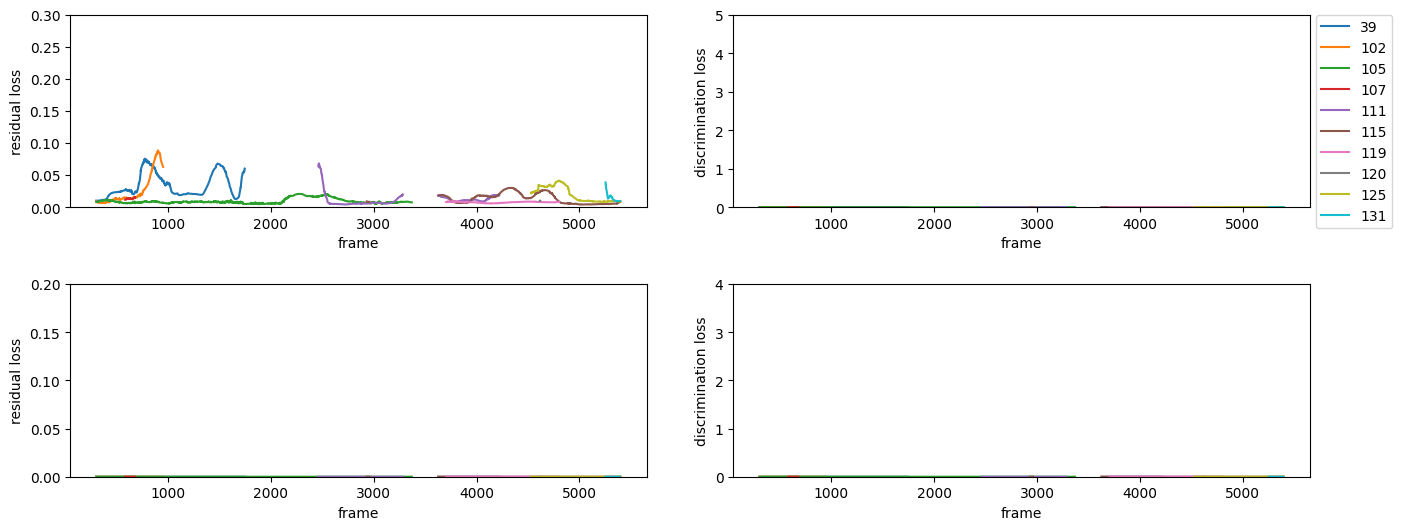

05


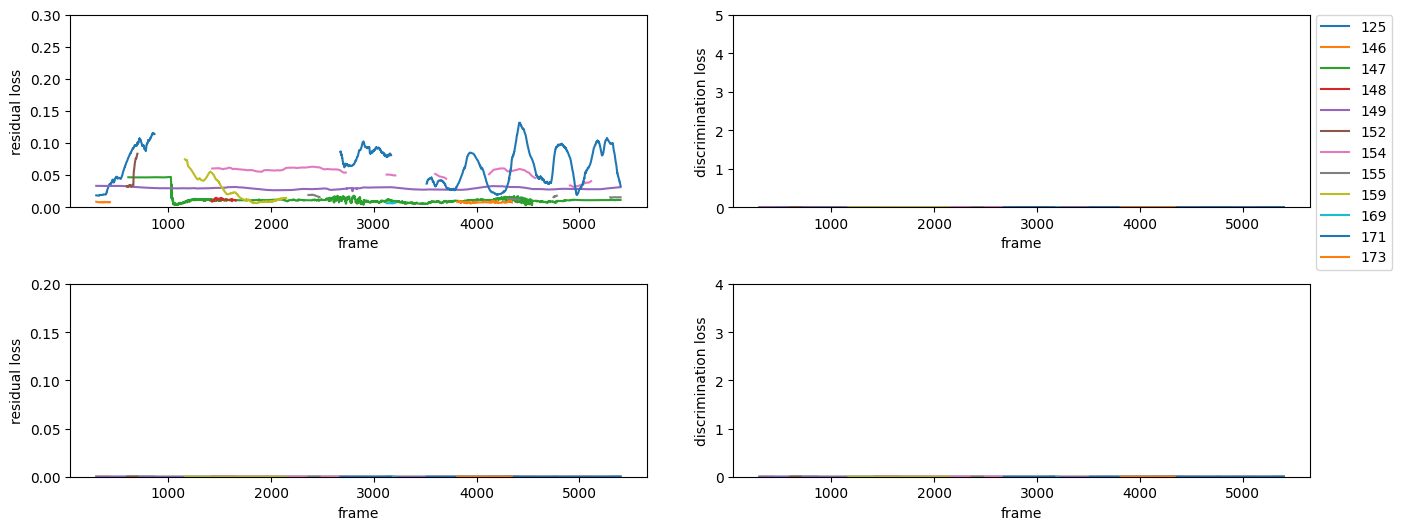

06


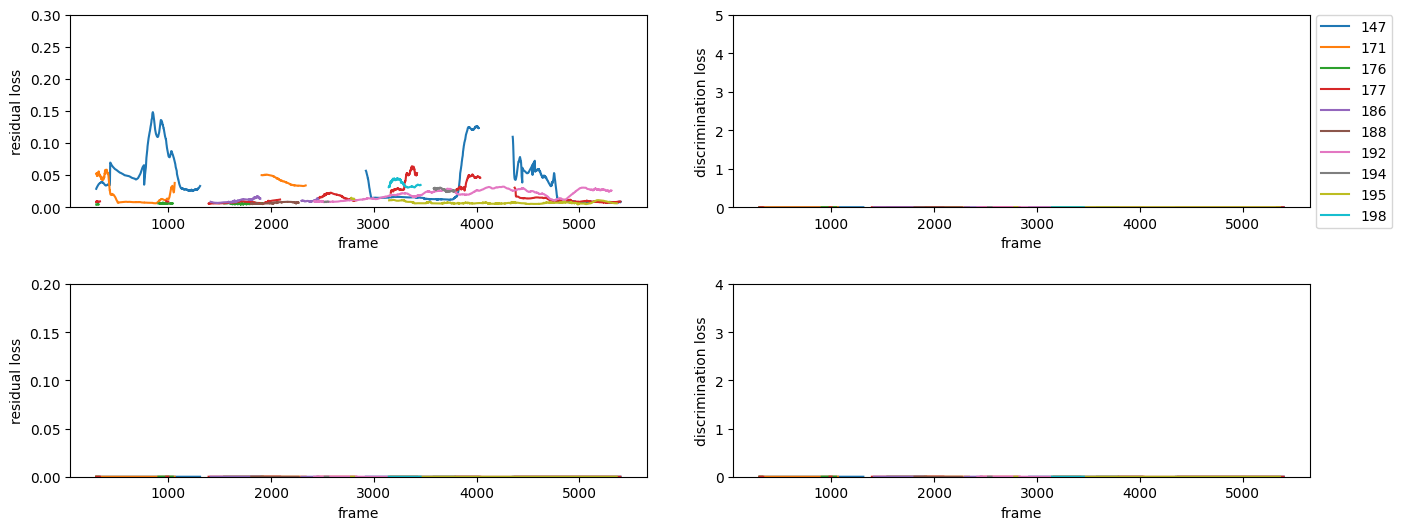

07


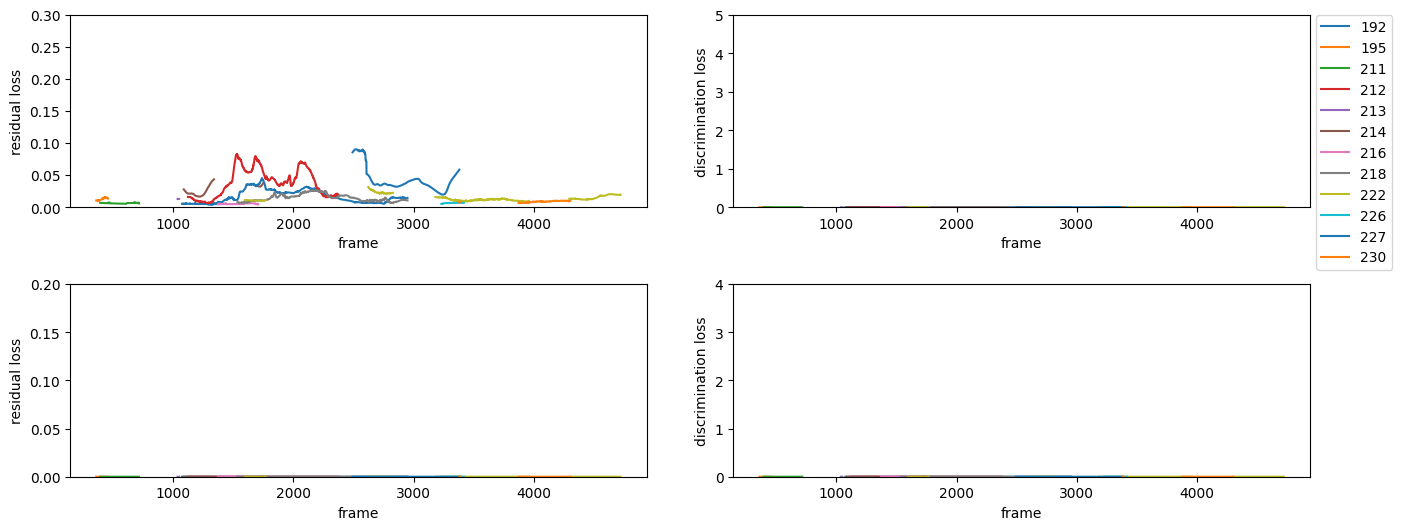

08


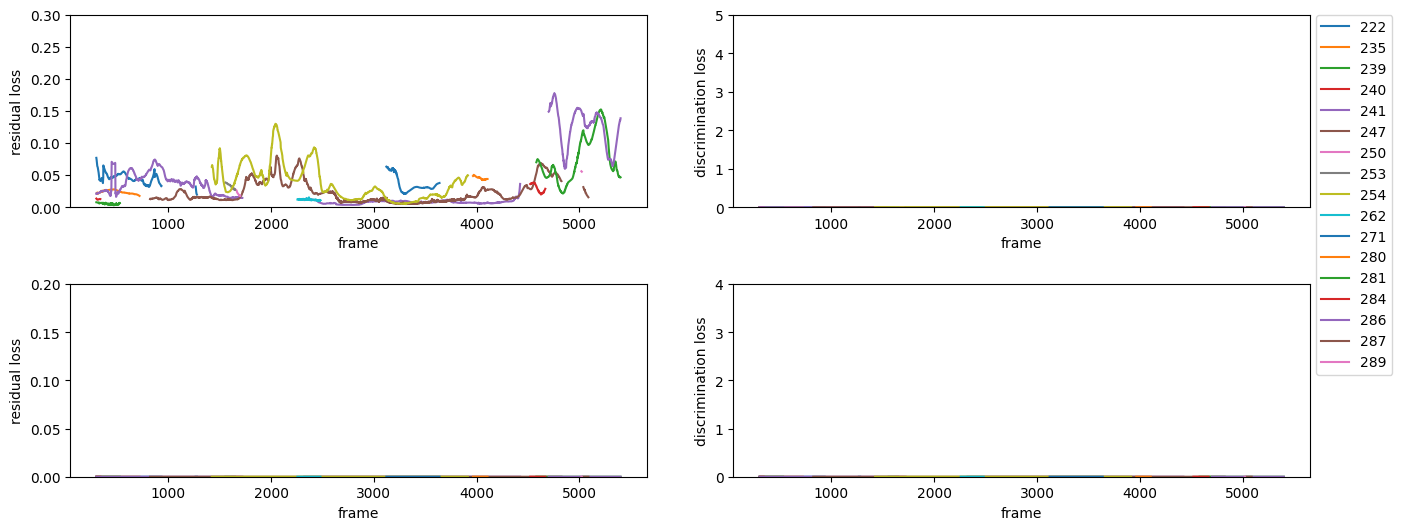

09


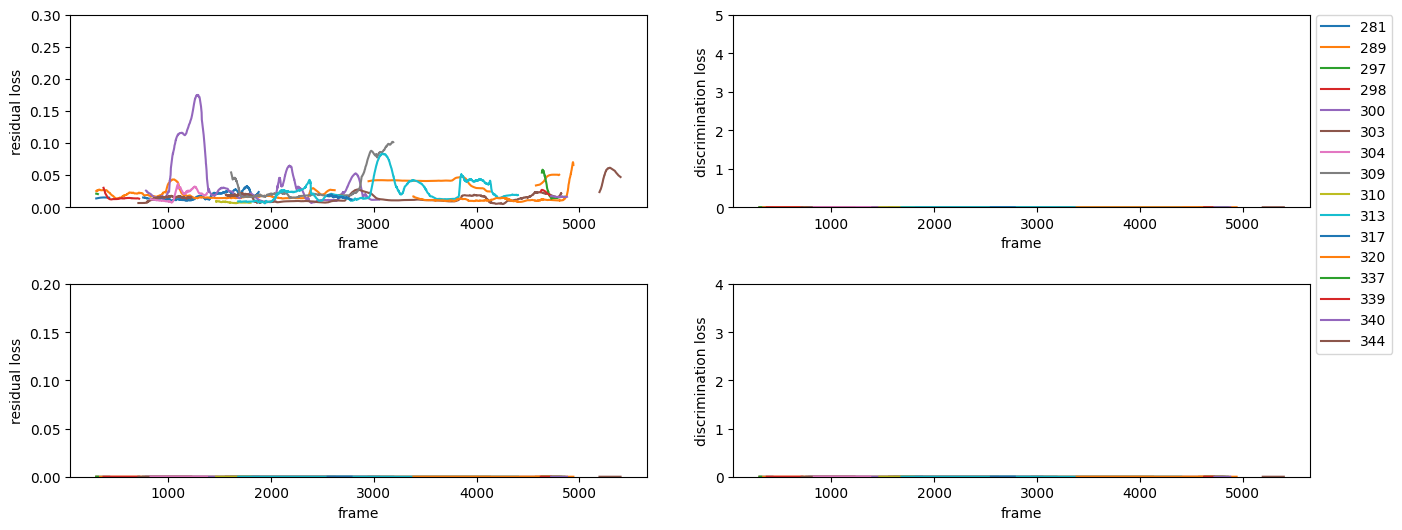

10


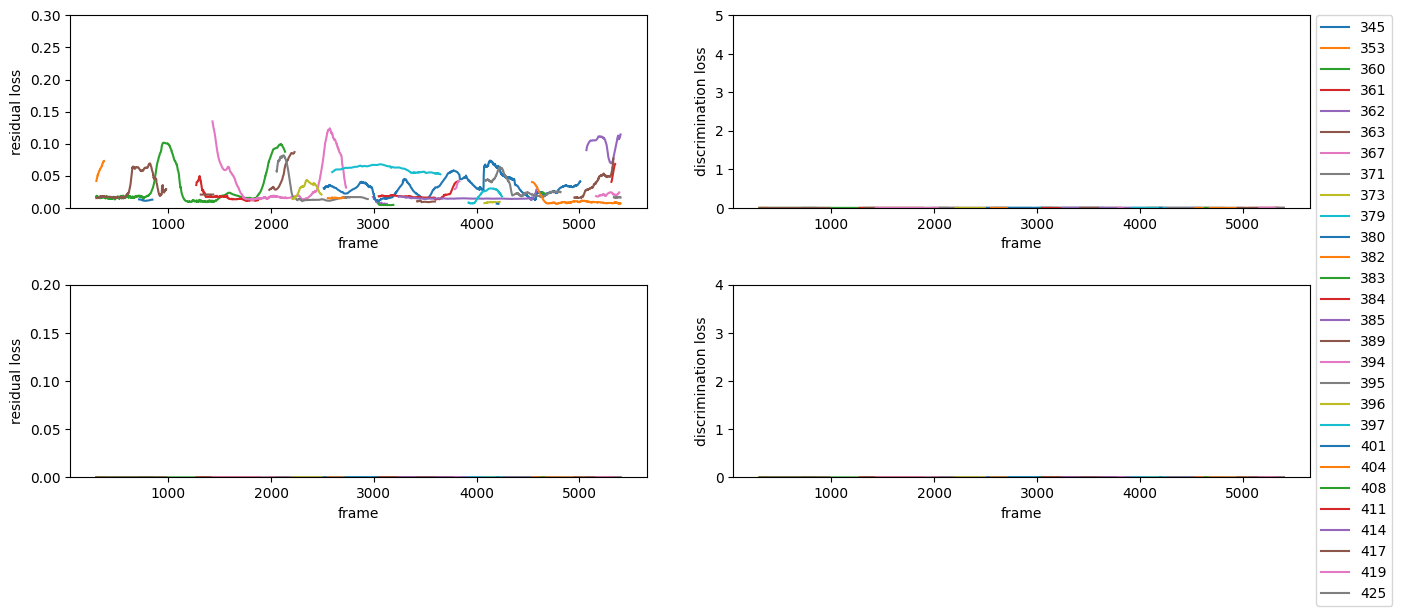

11


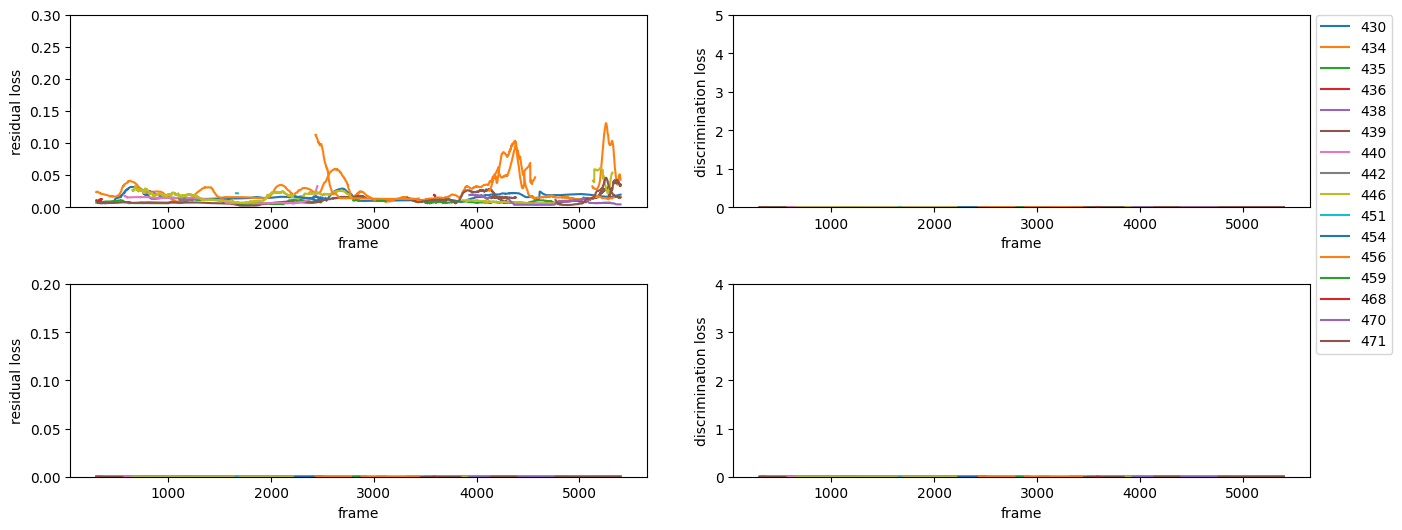

12


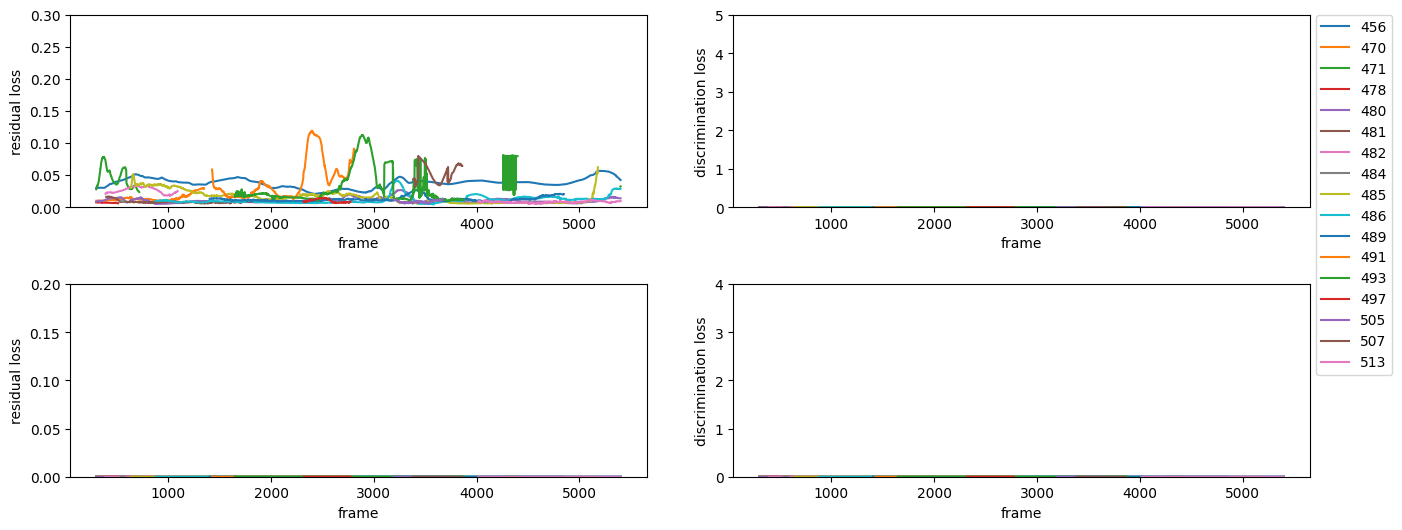

13


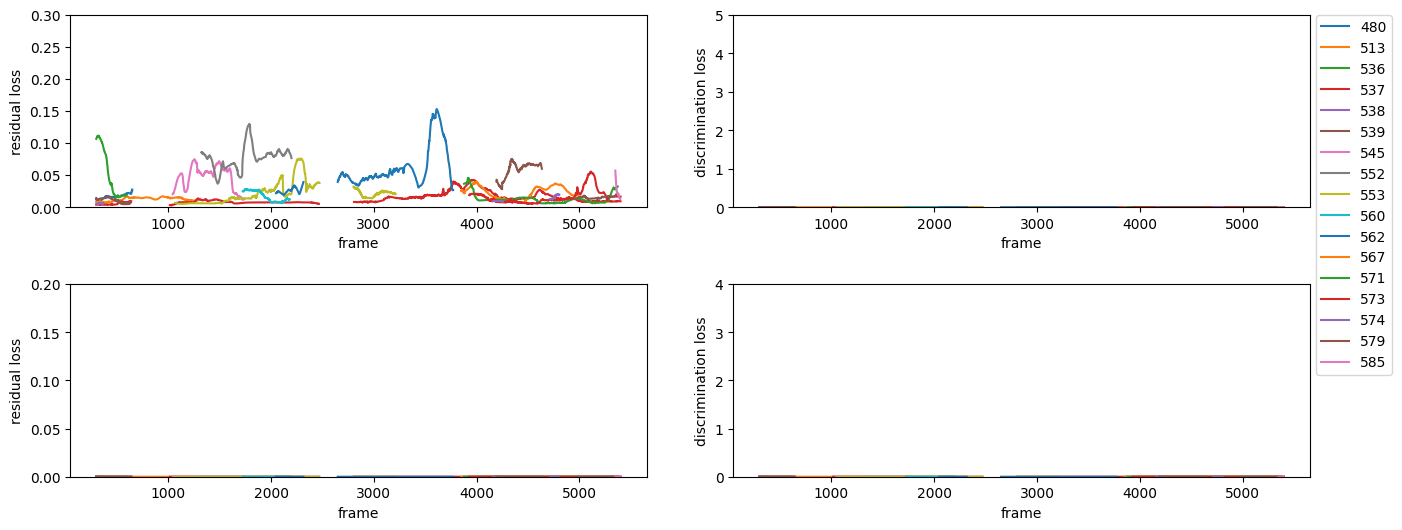

14


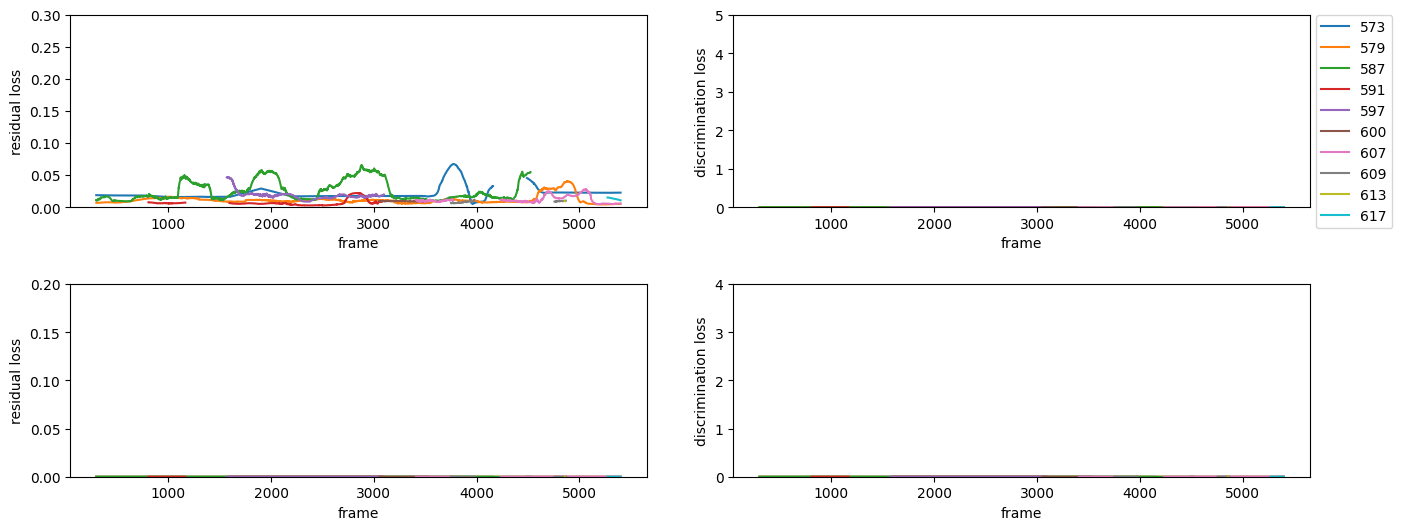

15


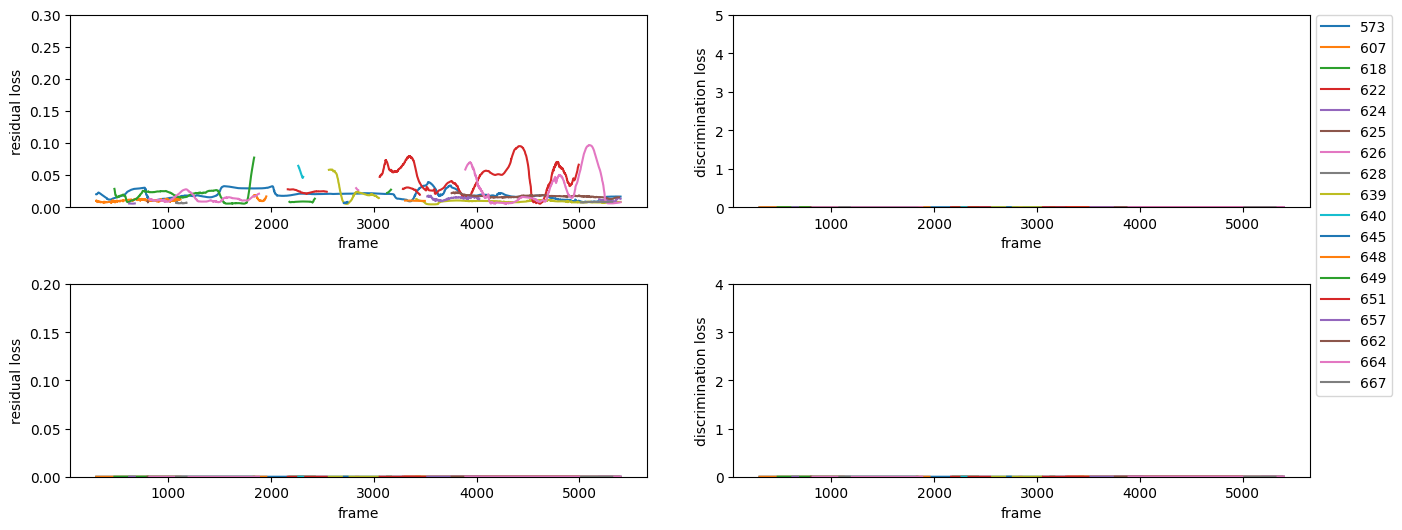

16


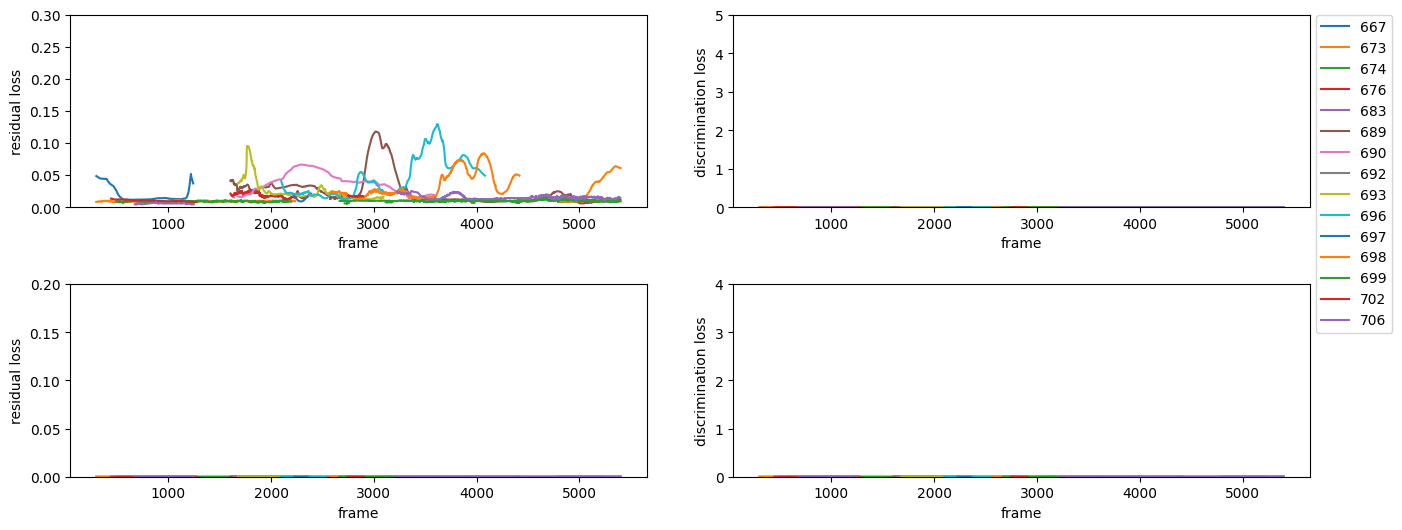

17


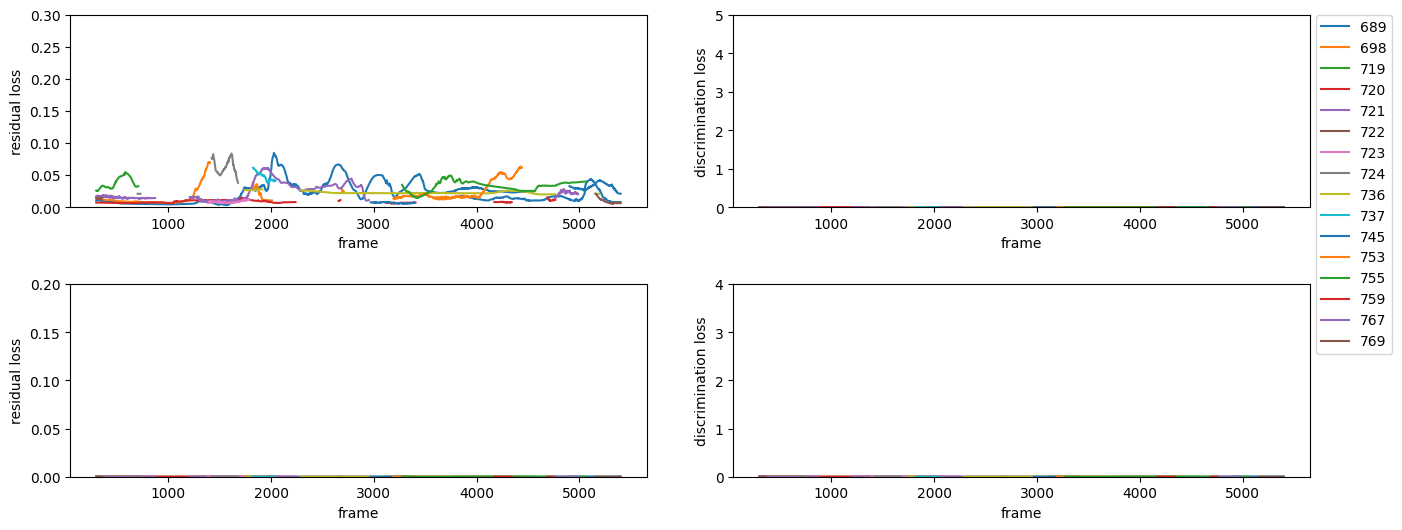

18


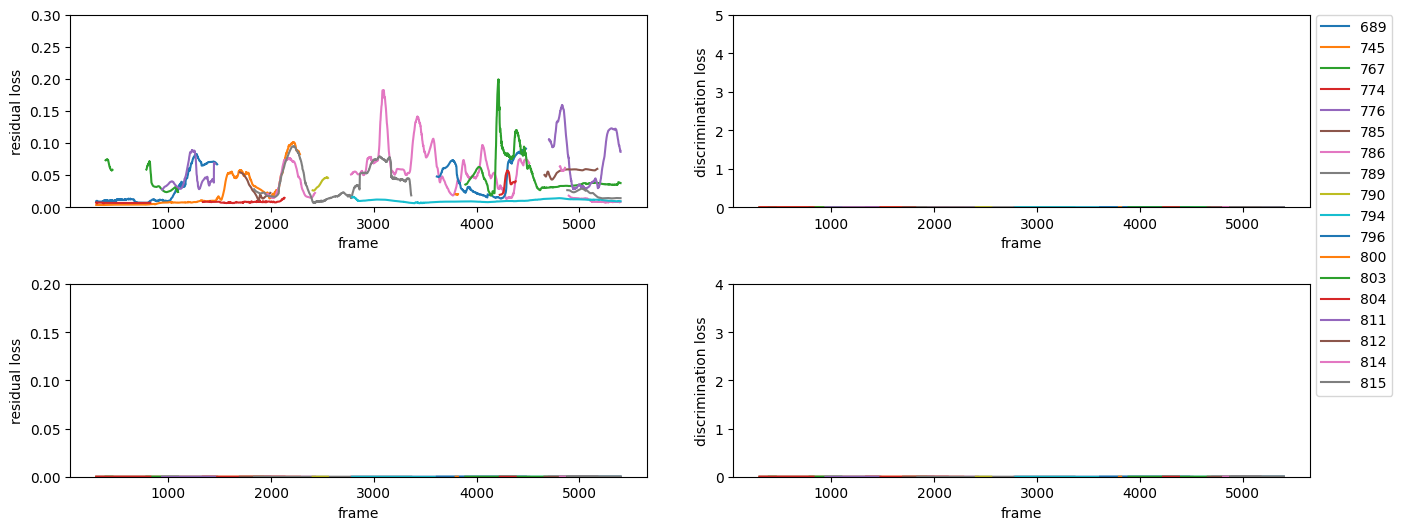

19


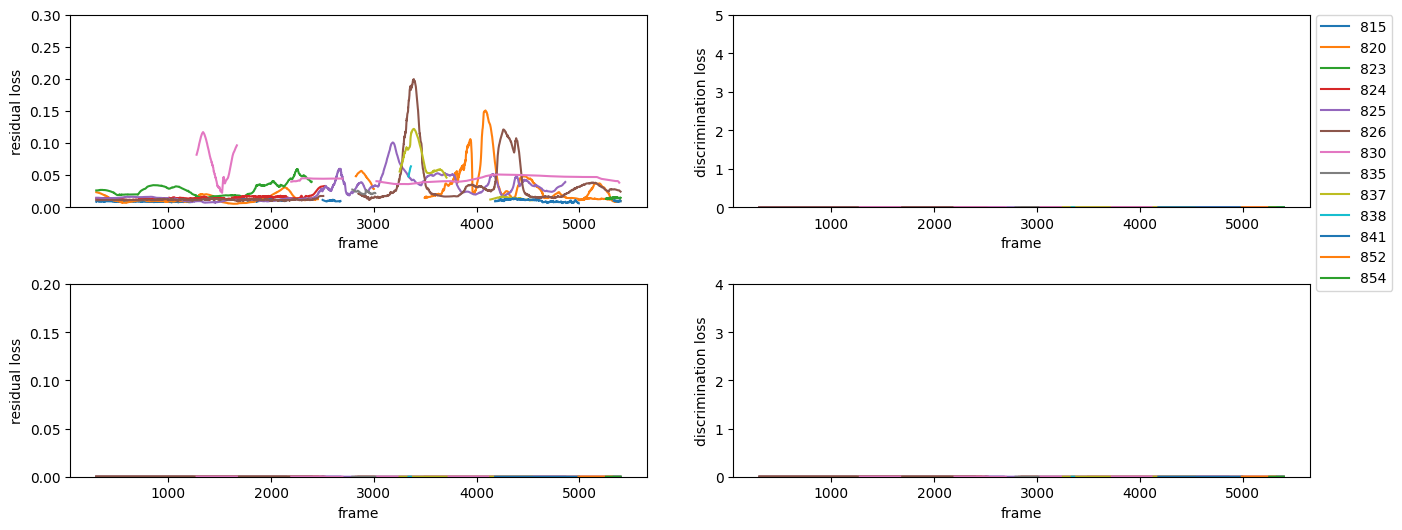

20


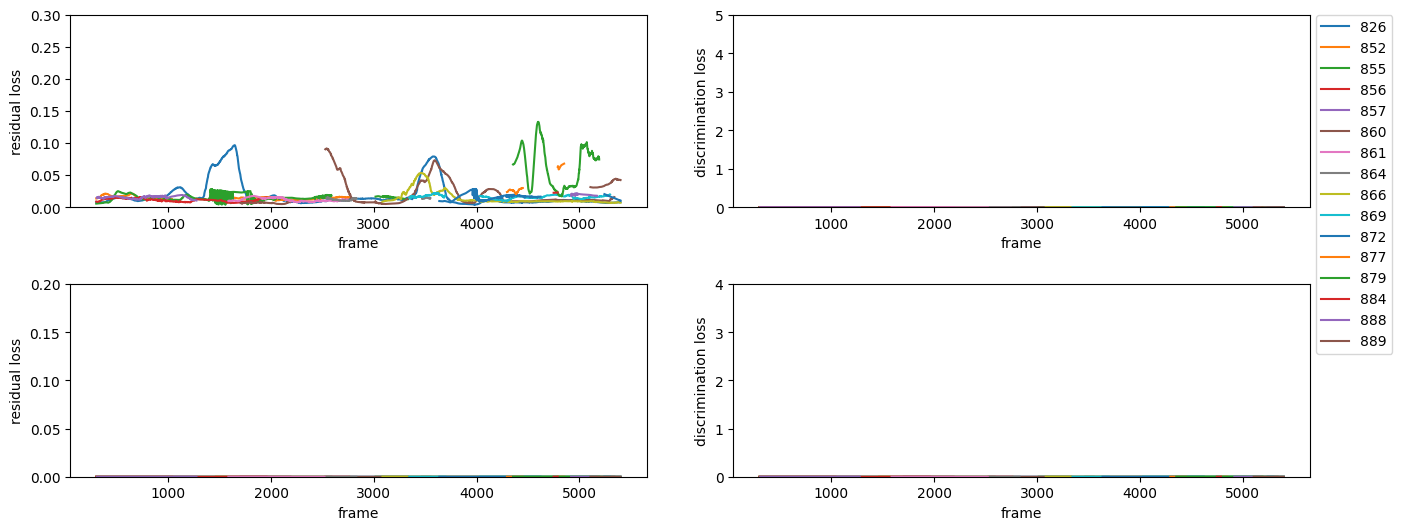

In [ ]:
plot(test_results_ind, max_frame_num, "test")

In [ ]:
# plot_anomaly(test_results_ind, max_frame_num, "test", lmd=0.9)